# Applications: Dress Style Transferring

## Editing image

In [1]:
# Step 1. Load up CLIPSeg model
from transformers import CLIPSegProcessor,CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)

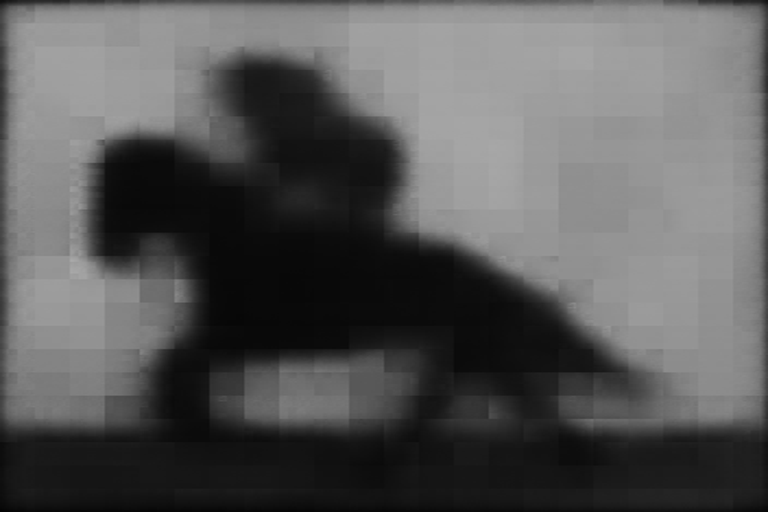

In [2]:
# Step 2. Get the initial mask output from CLIPSeg
from diffusers.utils import load_image
from diffusers.utils.pil_utils import numpy_to_pil
import torch

source_image = load_image("./images/clipseg_source_image.png")

prompts = ['the background']
inputs = processor(
    text             = prompts
    , images         = [source_image] * len(prompts)
    , padding        = True
    , return_tensors = "pt"
)

with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits
mask_data = torch.sigmoid(preds)

mask_data_numpy = mask_data.detach().unsqueeze(-1).numpy()
mask_pil = numpy_to_pil(mask_data_numpy)[0].resize(source_image.size)

mask_pil

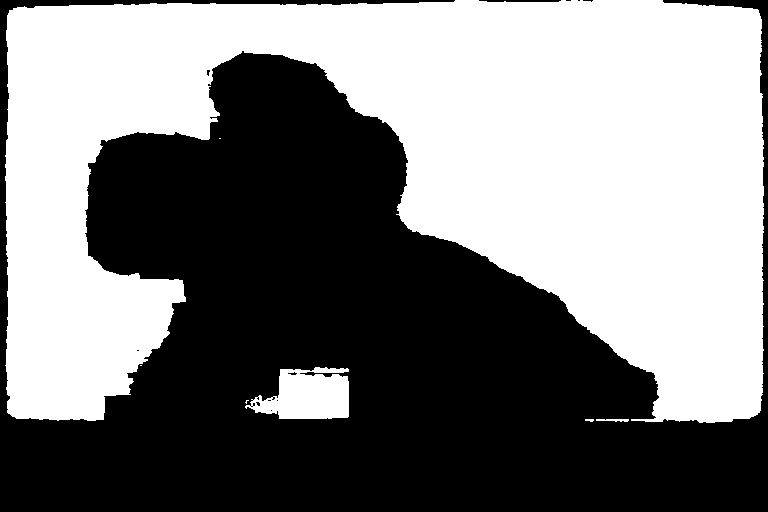

In [3]:
# generate binary mask
bw_thresh = 100
bw_fn = lambda x : 255 if x > bw_thresh else 0 
bw_mask_pil = mask_pil.convert("L").point(bw_fn, mode="1")
bw_mask_pil

### 1.1. Replacing image background content

/home/andrewzhu/storage_1t_1/az_git_folder/azcode/sd_venv_p310/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:1174: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionIn

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/azcode/sd_venv_p310/lib/python3.10/site-packages/diffusers/pipelines/deprecated/stable_diffusion_variants/pipeline_stable_diffusion_inpaint_legacy.py:141: FutureWarning: The class <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0. You can achieve exactly the same functionalityby loading your model into `StableDiffusionInpaintPipeline` instead. See https://github.com/huggingface/diffusers/pull/3533for more information.
  deprecate("legacy is outdated", "1.0.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose u

  0%|          | 0/45 [00:00<?, ?it/s]

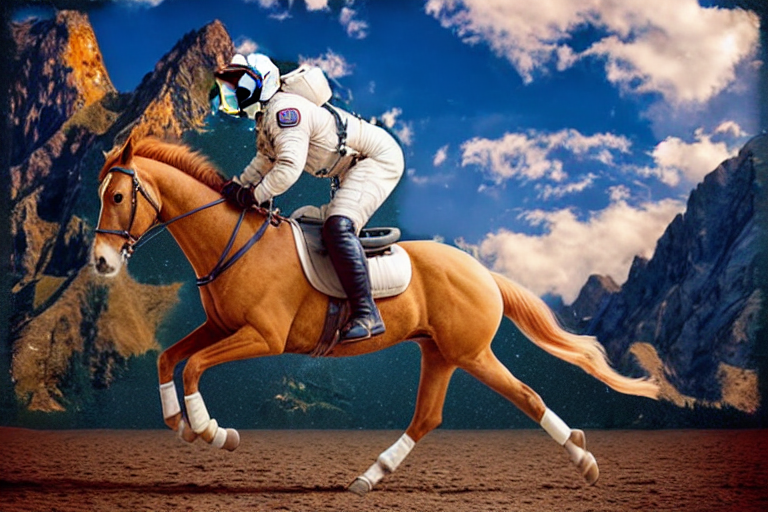

In [4]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4"
    , torch_dtype = torch.float16
    , safety_checker = None
).to("cuda:0")

sd_prompt = "blue sky and mountains"
out_image = inpaint_pipe(
    prompt          = sd_prompt
    , image         = source_image
    , mask_image    = bw_mask_pil
    , strength      = 0.9
    , generator     = torch.Generator("cuda:0").manual_seed(7)
).images[0]
out_image

### 1.2. Removing background 

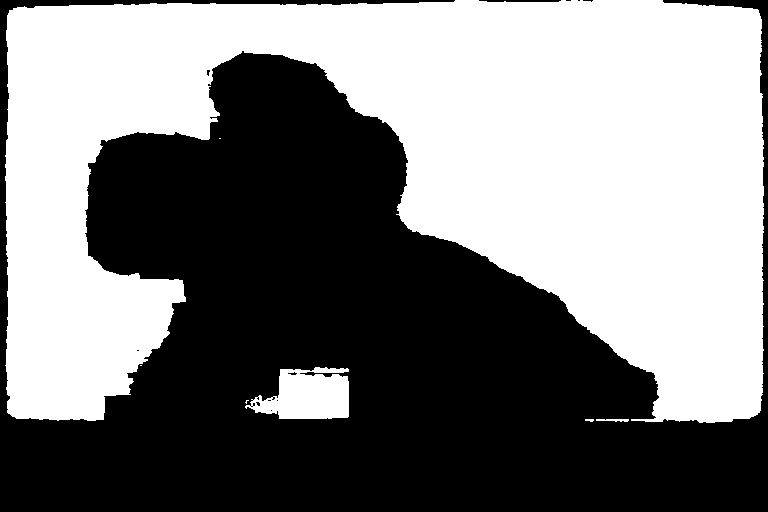

In [5]:
bw_thresh = 100
bw_fn = lambda x : 255 if x > bw_thresh else 0 
bw_mask_pil = mask_pil.convert("L").point(bw_fn, mode="1")
bw_mask_pil

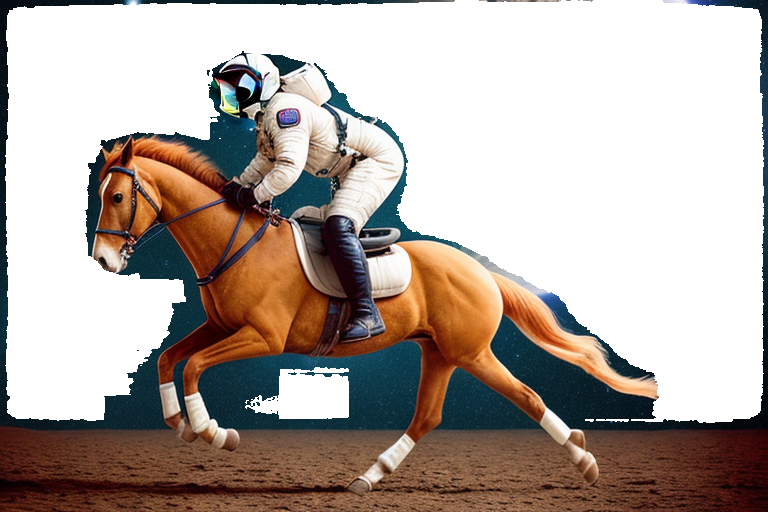

In [6]:
from PIL import Image, ImageOps
output_image = Image.new("RGBA", source_image.size, (255,255,255,255))
inverse_bw_mask_pil = ImageOps.invert(bw_mask_pil)
r = Image.composite(source_image ,output_image, inverse_bw_mask_pil)
r


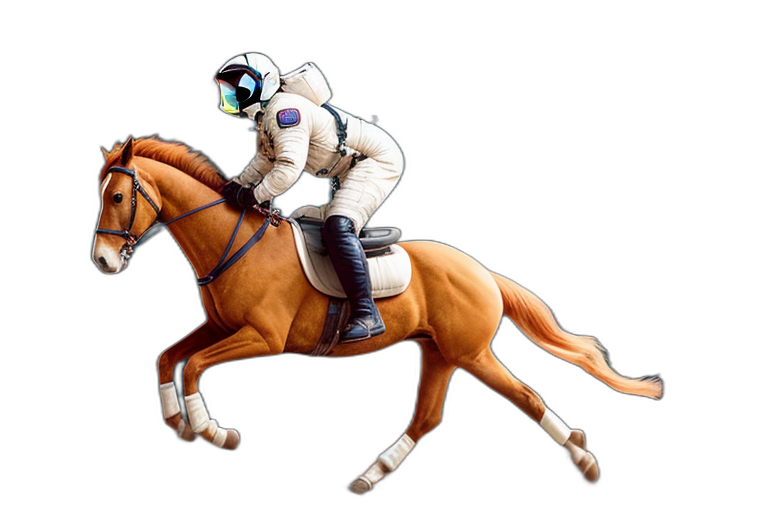

In [7]:
from rembg import remove
remove(source_image)

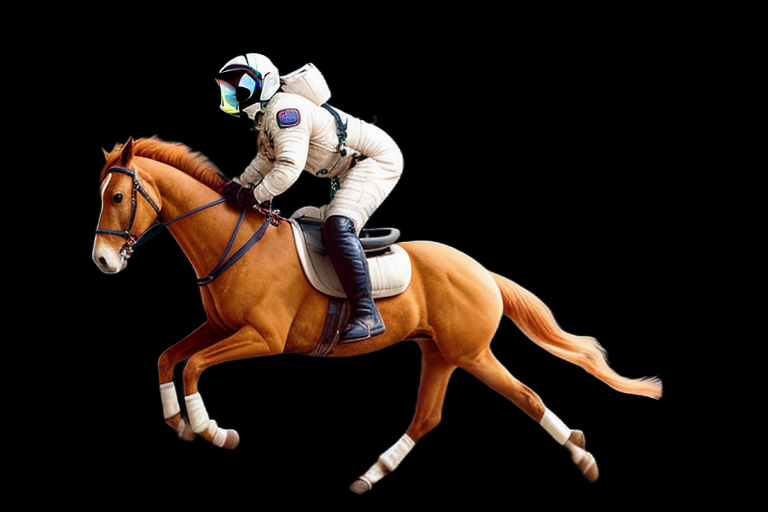

In [8]:
from rembg import remove
from PIL import Image
#white_bg = Image.new("RGBA", source_image.size, (255,255,255))
black_bg = Image.new("RGBA", source_image.size, (0,0,0))
image_wo_bg = remove(source_image)
img_wo_bg = Image.alpha_composite(black_bg, image_wo_bg)
img_wo_bg

## 2. Object and style transferring

### 2.1. Loading up a Stable Diffusion pipeline with IPAdapter

In [1]:
import torch
from transformers import CLIPVisionModelWithProjection
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter", 
    subfolder   = "models/image_encoder",
    torch_dtype = torch.float16,
).to("cuda:0")

In [2]:
from diffusers import StableDiffusionImg2ImgPipeline
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    image_encoder   = image_encoder, 
    torch_dtype     = torch.float16, 
    safety_checker  = None
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/azcode/sd_venv_p310/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
pipeline.load_ip_adapter(
    "h94/IP-Adapter", 
    subfolder       = "models", 
    weight_name     = "ip-adapter_sd15.bin"
)

### 2.2 Transferring style

  0%|          | 0/25 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

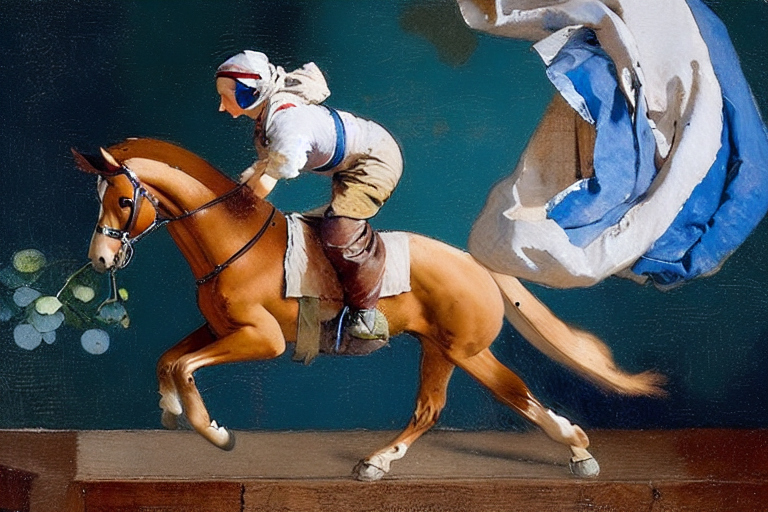

In [12]:
from diffusers.utils import load_image

source_image = load_image("./images/clipseg_source_image.png")
ip_image = load_image("./images/vermeer.png")

pipeline.to("cuda:0")

image = pipeline(
    prompt                   = 'best quality, high quality'
    , negative_prompt        = "monochrome,lowres, bad anatomy,low quality" 
    , image                  = source_image
    , ip_adapter_image       = ip_image 
    , num_images_per_prompt  = 1 
    , num_inference_steps    = 50
    , strength               = 0.5
    , generator              = torch.Generator("cuda:0").manual_seed(1)
).images[0]

pipeline.to("cpu")
torch.cuda.empty_cache()
image

